<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Tri_vector_emergence_from_a_single_axis_(Phi)_instability_AJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

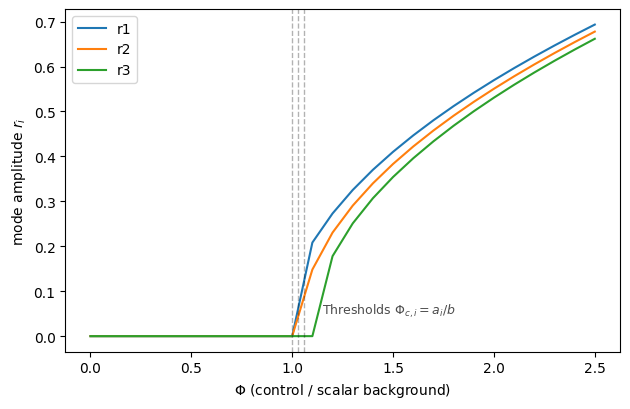

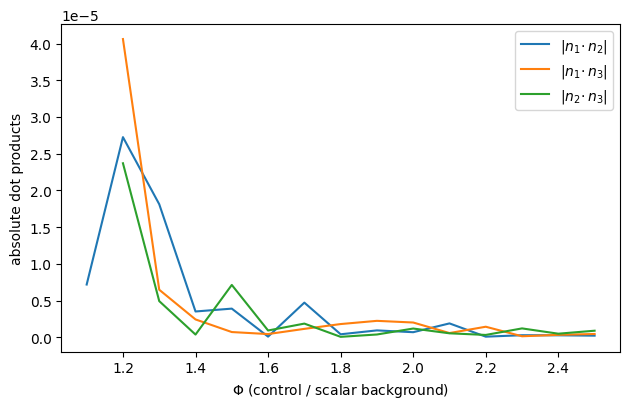

Phi≈0.90  r=[0. 0. 0.]   |dots|=[nan, nan, nan]   F=0.000000
Phi≈1.20  r=[0.27304075 0.23048724 0.17804255]   |dots|=[np.float64(2.725713372020433e-05), np.float64(4.0609228707931544e-05), np.float64(2.3701691084704324e-05)]   F=-0.014190
Phi≈2.00  r=[0.5696958  0.55056824 0.53075106]   |dots|=[np.float64(7.048417060839807e-07), np.float64(2.0235140170132837e-06), np.float64(1.2038442570583285e-06)]   F=-0.441690


'\n- The control Phi here is the same scalar field Φ used in the Axis Model; crossing b*Phi > a_i\n  is the scalar background/VEV reaching an instability threshold for vector displacements.\n- With a1<a2<a3 (SEQUENTIAL=True) you see a clean cascade; with equal a_i the onset is simultaneous.\n- Set SAVE_FIGS=True to export fig_amplitudes_vs_phi.pdf and fig_dotproducts_vs_phi.pdf.\n'

In [ ]:
# === Tri-vector emergence from a single-axis (Phi) instability ===
# Final version: sequential or symmetric thresholds, masked dot-products, annotated phi_c, PDF export.
# Generates two figures used in the paper appendix and prints representative states.

import numpy as np
from numpy.random import default_rng
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ----------------------- Configuration ---------------------------------------
SEQUENTIAL = True     # True => a1 < a2 < a3 (cascade); False => all equal (symmetric onset)
RNG_SEED   = 42       # deterministic runs
N_STARTS   = 32       # multi-starts per Phi
MAXITER    = 2000     # optimizer iterations
PHI_MIN, PHI_MAX, PHI_STEPS = 0.0, 2.5, 26
SAVE_FIGS  = True     # set True to export PDFs
MASK_EPS   = 1e-6     # mask dot-products until both modes in a pair are nonzero

# ------------------------ Model Parameters ------------------------------------
# (a_i - b Phi) r_i^2 term; slight asymmetry staggers onsets
if SEQUENTIAL:
    a_vec = np.array([1.00, 1.03, 1.06])   # cascade thresholds: r1 -> r2 -> r3
else:
    a_vec = np.array([1.00, 1.00, 1.00])   # simultaneous onset
b = 1.0   # coupling to Phi (instability when b*Phi > a_i)
c = 1.0   # quartic self
d = 0.6   # quartic cross-amplitude (prevents single-mode monopoly)
e = 2.0   # orthogonality penalty (>0 -> n_i ⟂ n_j when multiple modes)
lam = 50.0  # soft unit-norm penalty for directions

# ------------------------ Helpers & Energy ------------------------------------
rng = default_rng(RNG_SEED)

def split_vars(x):
    """Unpack optimization vector into amplitudes r and directions n1,n2,n3."""
    r  = np.clip(x[0:3], 0.0, None)  # nonnegativity by clipping (ok for energy minimization)
    n1 = x[3:6]; n2 = x[6:9]; n3 = x[9:12]
    return r, (n1, n2, n3)

def energy(x, Phi):
    """Landau free energy with orthogonality enforcement when multiple modes are nonzero."""
    r, (n1, n2, n3) = split_vars(x)

    # soft unit-norm constraints
    unit_pen = lam * ((np.dot(n1,n1)-1.0)**2 + (np.dot(n2,n2)-1.0)**2 + (np.dot(n3,n3)-1.0)**2)

    # scalar-driven quadratic + quartics
    quad   = np.sum((a_vec - b*Phi) * r**2)
    self4  = c * np.sum(r**4)
    cross4 = d * (r[0]**2*r[1]**2 + r[0]**2*r[2]**2 + r[1]**2*r[2]**2)

    # orthogonality penalty (active only when multiple r_i > 0)
    dotsq_12 = (np.dot(n1, n2))**2
    dotsq_13 = (np.dot(n1, n3))**2
    dotsq_23 = (np.dot(n2, n3))**2
    ortho    = e * (dotsq_12*r[0]**2*r[1]**2 +
                    dotsq_13*r[0]**2*r[2]**2 +
                    dotsq_23*r[1]**2*r[2]**2)

    return quad + self4 + cross4 + ortho + unit_pen

def random_start():
    """Random initial state for multi-start globalization."""
    r0 = rng.random(3)
    n0 = rng.normal(size=(3,3))
    return np.concatenate([r0, n0.reshape(-1)])

def minimize_for_phi(Phi, n_starts=N_STARTS, maxiter=MAXITER):
    """Multi-start L-BFGS to find a low-energy minimum at a given Phi."""
    best_val = np.inf
    best_x   = None
    for _ in range(n_starts):
        x0  = random_start()
        res = minimize(energy, x0, args=(Phi,),
                       method="L-BFGS-B",
                       options=dict(maxiter=maxiter, ftol=1e-12))
        if res.fun < best_val:
            best_val = res.fun
            best_x   = res.x.copy()
    return best_x, best_val

# ------------------------- Sweep Phi and collect solutions ---------------------
Phi_vals = np.linspace(PHI_MIN, PHI_MAX, PHI_STEPS)
solutions = []

for Phi in Phi_vals:
    x_star, f_star = minimize_for_phi(Phi)
    r, (n1, n2, n3) = split_vars(x_star)
    # normalize directions for reporting (unit penalty keeps them near unit)
    n1 = n1 / (np.linalg.norm(n1) + 1e-12)
    n2 = n2 / (np.linalg.norm(n2) + 1e-12)
    n3 = n3 / (np.linalg.norm(n3) + 1e-12)

    # mask dot-products until both amplitudes in a pair are > MASK_EPS
    dots = []
    pairs = [(0,1), (0,2), (1,2)]
    vecs  = (n1, n2, n3)
    for (i,j) in pairs:
        if r[i] > MASK_EPS and r[j] > MASK_EPS:
            dots.append(abs(np.dot(vecs[i], vecs[j])))
        else:
            dots.append(np.nan)

    solutions.append(dict(Phi=Phi, r=r, n=(n1,n2,n3), dots=dots, F=f_star))

# ------------------------------- Plots -----------------------------------------
# Plot 1: amplitudes with annotated thresholds
plt.figure(figsize=(6.4, 4.2))
plt.plot(Phi_vals, [s["r"][0] for s in solutions], label="r1")
plt.plot(Phi_vals, [s["r"][1] for s in solutions], label="r2")
plt.plot(Phi_vals, [s["r"][2] for s in solutions], label="r3")
plt.xlabel(r"$\Phi$ (control / scalar background)")
plt.ylabel(r"mode amplitude $r_i$")
plt.legend()

# annotate thresholds Phi_c,i = a_i / b
phi_c = a_vec / b
for v in phi_c:
    plt.axvline(v, color='k', linestyle='--', alpha=0.3, linewidth=1)
plt.text(1.15, 0.05, r"Thresholds $\Phi_{c,i}=a_i/b$", fontsize=9, alpha=0.7)

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("fig_amplitudes_vs_phi.png")
plt.show()

# Plot 2: absolute dot-products (masked pre-condensation)
plt.figure(figsize=(6.4, 4.2))
labels = [r"$|n_1\!\cdot n_2|$", r"$|n_1\!\cdot n_3|$", r"$|n_2\!\cdot n_3|$"]
for j in range(3):
    plt.plot(Phi_vals, [s["dots"][j] for s in solutions], label=labels[j])
plt.xlabel(r"$\Phi$ (control / scalar background)")
plt.ylabel(r"absolute dot products")
plt.legend()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("fig_dotproducts_vs_phi.png")
plt.show()

# -------------------------- Representative outputs -----------------------------
def nearest_solution(phi_target):
    return min(solutions, key=lambda S: abs(S["Phi"]-phi_target))

for phi_target in [0.9, 1.2, 2.0]:
    s = nearest_solution(phi_target)
    print(f"Phi≈{s['Phi']:.2f}  r={s['r']}   |dots|={s['dots']}   F={s['F']:.6f}")

# -------------------------- Notes-------------------------------
"""
- The control Phi here is the same scalar field Φ used in the Axis Model; crossing b*Phi > a_i
  is the scalar background/VEV reaching an instability threshold for vector displacements.
- With a1<a2<a3 (SEQUENTIAL=True) you see a clean cascade; with equal a_i the onset is simultaneous.
- Set SAVE_FIGS=True to export fig_amplitudes_vs_phi.pdf and fig_dotproducts_vs_phi.pdf.
"""
